In [58]:
import numpy as np
import pickle
import os
import json
from scipy.stats import mode
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import seaborn as sns
from matplotlib import pyplot as plt
import xgboost

model_path = os.path.join(os.getcwd(), 'model_rf.pkl')

data_partition_path = '/media/iittp/new volume'
dataset_tiles_dir = 'multispectral_validation_tiles'
data_json_path = os.path.join(data_partition_path, dataset_tiles_dir, 'data.json')

features_dir = os.path.join(os.getcwd(), 'multispectral_validation_glcm_vege_features')

with open(model_path, 'rb') as f:
    model = pickle.load(f)

with open(data_json_path) as f:
    data_json = json.load(f)

classes = list(data_json.keys())
classes_id = {cls:i for i,cls in enumerate(classes)}
print("\n".join([f"ID: {i}, CLASS: {cls}" for i, cls in enumerate(classes)]))

ID: 0, CLASS: banana
ID: 1, CLASS: elephant_foot
ID: 2, CLASS: paddy
ID: 3, CLASS: turmeric


In [59]:
images = {}
image_features = {}
for cls in classes:
    images[cls] = {}
    cls_features = np.load(os.path.join(features_dir, f"{cls}.npz"))['features']
    image_features[cls] = cls_features
    print(f"Loaded {cls_features.shape} from class {cls}")

    for i, fname in enumerate(data_json[cls]):
        fname_base = fname.rsplit('_', 1)[0]

        if fname_base not in images[cls]:
            images[cls][fname_base] = []

        images[cls][fname_base].append(cls_features[i])
    
    for fname in images[cls]:
        images[cls][fname] = np.array(images[cls][fname])

Loaded (708, 146) from class banana
Loaded (660, 146) from class elephant_foot
Loaded (924, 146) from class paddy
Loaded (444, 146) from class turmeric


In [60]:
predictions = {}
majority_votes = {}
for cls in classes:
    predictions[cls] = {}
    majority_votes[cls] = {}

    for i, fname in enumerate(images[cls]):
        predictions[cls][fname] = model.predict(images[cls][fname])
        majority_votes[cls][fname], _ = mode(predictions[cls][fname])

In [61]:
def plot_confusion_matrix(conf_matrix, classes=classes, title='Confusion Matrix', cmap='Blues'):
    """
    Plots a confusion matrix with class labels.
    
    Parameters:
    - conf_matrix: A square confusion matrix of shape [N, N].
    - classes: A list of class names corresponding to the rows and columns of the confusion matrix.
    - title: Title of the plot.
    - cmap: Color map for heatmap.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes,
                cbar=False, square=True, linewidths=0.5, linecolor='gray')

    plt.title(title)
    plt.xlabel('True Labels')
    plt.ylabel('Predicted Labels')

    plt.show()

def calculate_classification_metrics(cm, class_names=classes):
    """
    Calculate accuracy, precision, recall, and F1 score per class from a confusion matrix.
    
    Args:
        cm (numpy.ndarray): Confusion matrix where cm[i, j] is the number of instances
                             where class i was predicted as class j. 
                             Rows represent predicted labels and columns represent true labels.

    Returns:
        dict: A dictionary with metrics for each class.
    """
    # Number of classes
    num_classes = cm.shape[0]

    # Initialize the dictionary to store metrics
    metrics = {}

    for i in range(num_classes):
        # True positives (TP): Predicted as class i and the true label is also i
        TP = cm[i, i]

        # False positives (FP): Predicted as class i, but true label is not class i
        FP = np.sum(cm[i, :]) - TP  # Sum of row i, excluding the diagonal

        # False negatives (FN): True label is class i, but predicted as something else
        FN = np.sum(cm[:, i]) - TP  # Sum of column i, excluding the diagonal

        # True negatives (TN): All other instances that are not in class i
        TN = np.sum(cm) - (TP + FP + FN)

        # Precision, recall, F1 score calculation
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Accuracy is the sum of TP and TN divided by total number of samples
        accuracy = (TP + TN) / np.sum(cm)

        # Store metrics in the dictionary for the class
        metrics[class_names[i]] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score
        }

    return metrics

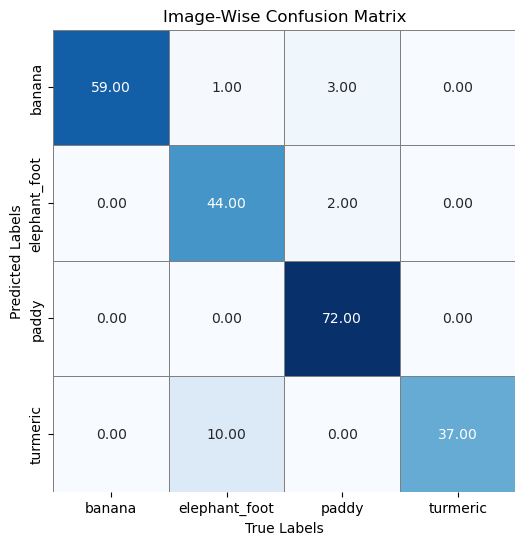

In [62]:
cm_image = np.zeros((len(classes), len(classes)))     #confusion matrix
for cls in classes:
    gt = classes_id[cls]
    preds = majority_votes[cls].values()

    for pred in preds:
        cm_image[pred][gt]+=1

plot_confusion_matrix(cm_image, title="Image-Wise Confusion Matrix")

In [63]:
print(json.dumps(calculate_classification_metrics(cm_image), indent=4))

{
    "banana": {
        "accuracy": 0.9824561403508771,
        "precision": 0.9365079365079365,
        "recall": 1.0,
        "f1_score": 0.9672131147540983
    },
    "elephant_foot": {
        "accuracy": 0.9429824561403509,
        "precision": 0.9565217391304348,
        "recall": 0.8,
        "f1_score": 0.8712871287128713
    },
    "paddy": {
        "accuracy": 0.9780701754385965,
        "precision": 1.0,
        "recall": 0.935064935064935,
        "f1_score": 0.9664429530201343
    },
    "turmeric": {
        "accuracy": 0.956140350877193,
        "precision": 0.7872340425531915,
        "recall": 1.0,
        "f1_score": 0.880952380952381
    }
}


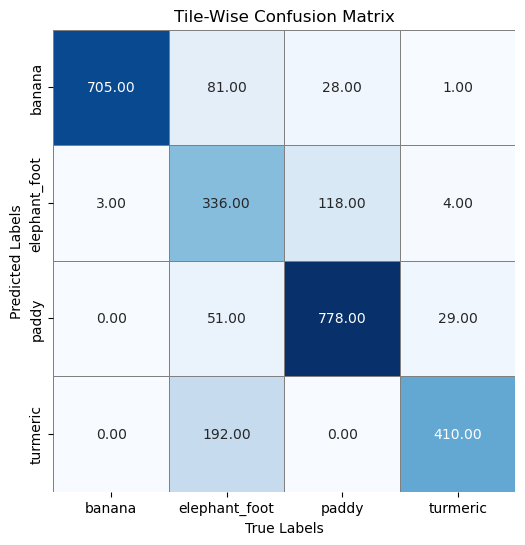

In [64]:
cm_tile = np.zeros((len(classes), len(classes)))
for cls in classes:
    gt = classes_id[cls]
    preds = predictions[cls].values()

    for pred in preds:
        for tile_pred in pred:
            cm_tile[tile_pred][gt]+=1


plot_confusion_matrix(cm_tile, title="Tile-Wise Confusion Matrix")

In [65]:
print(json.dumps(calculate_classification_metrics(cm_tile), indent=4))

{
    "banana": {
        "accuracy": 0.9586988304093568,
        "precision": 0.8650306748466258,
        "recall": 0.9957627118644068,
        "f1_score": 0.9258043335521995
    },
    "elephant_foot": {
        "accuracy": 0.8358918128654971,
        "precision": 0.7288503253796096,
        "recall": 0.509090909090909,
        "f1_score": 0.599464763603925
    },
    "paddy": {
        "accuracy": 0.9173976608187134,
        "precision": 0.9067599067599068,
        "recall": 0.841991341991342,
        "f1_score": 0.8731762065095398
    },
    "turmeric": {
        "accuracy": 0.9173976608187134,
        "precision": 0.6810631229235881,
        "recall": 0.9234234234234234,
        "f1_score": 0.7839388145315487
    }
}
